# SOSE SIC thickness timeseries/threshold

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.2cb72ed1ea14418484bf6ce6e8330eb8/status,


In [42]:
client.close()
cluster.close()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import json
import fsspec
import gcsfs
import xmitgcm

In [4]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [5]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["SOSE"].to_dask()

In [6]:
coordsr = ds.coords.to_dataset().reset_coords()
dsr = ds.reset_coords(drop=True)
dsr

,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,439 Tasks,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,439 Tasks,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
dsr.SIheff

<xarray.DataArray 'SIheff' (time: 438, YC: 320, XC: 2160)>
dask.array<open_dataset-a050d735e682b2f36299dae082225da8SIheff, shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -25.04 -24.87 -24.71
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      SEAICE effective ice thickness
    standard_name:  SIheff
    units:          m

In [8]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 95
left_lon =  310
right_lon = 880

#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

coords1 = coordsr.roll(XC=700, roll_coords=True).isel(**lat_range, **lon_range)
ds1 = dsr.roll(XC=700, roll_coords=True).isel(**lat_range, **lon_range)

new_xc = np.arange(-65, 30, 0.16666794)
coords = coords1.assign_coords(coords={'XC' : new_xc})
ds = ds1.assign_coords(coords={'XC' : new_xc})

sit = ds.SIheff

In [9]:
sit = ds.SIheff

In [10]:
sit

<xarray.DataArray 'SIheff' (time: 438, YC: 95, XC: 570)>
dask.array<getitem, shape=(438, 95, 570), dtype=float32, chunksize=(1, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 -65.0 -64.83 -64.67 -64.5 ... 29.33 29.5 29.67 29.83
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      SEAICE effective ice thickness
    standard_name:  SIheff
    units:          m

In [11]:
mask = coords.hFacC[0]>0

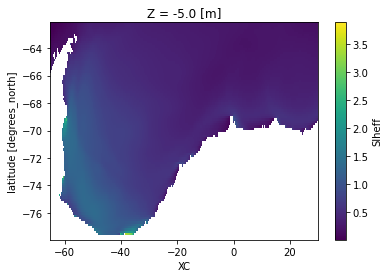

In [12]:
sit.where(mask).mean('time').plot();

In [13]:
sit_thresh = sit.where(sit <= 0.12).where(mask)
sit_thresh

<xarray.DataArray 'SIheff' (time: 438, YC: 95, XC: 570)>
dask.array<where, shape=(438, 95, 570), dtype=float32, chunksize=(1, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 -65.0 -64.83 -64.67 -64.5 ... 29.33 29.5 29.67 29.83
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Z        float32 -5.0
Attributes:
    long_name:      SEAICE effective ice thickness
    standard_name:  SIheff
    units:          m

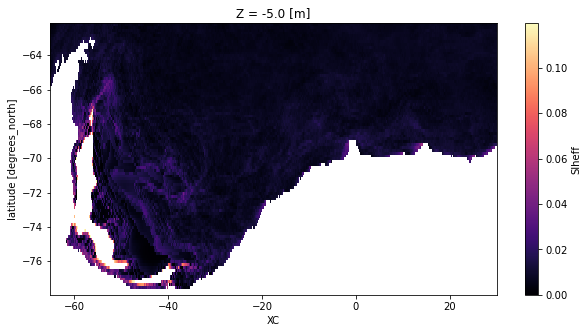

In [14]:
#look at same time as outcropping
sit_thresh.mean('time').plot(cmap='magma', figsize=(10,5));

## Check outcropping

In [15]:
salt = ds.SALT
temp = ds.THETA
pref = 2000

In [16]:
salt.shape

(438, 42, 95, 570)

In [17]:
temp.shape

(438, 42, 95, 570)

In [22]:
sigma2 = xr.apply_ufunc(jmd95numba.rho, salt, temp, pref,
                            output_dtypes=[temp.dtype],
                            dask='parallelized').reset_coords(drop=True)

In [23]:
sigma2

,Array,Chunk
Bytes,3.71 GiB,8.68 MiB
Shape,"(438, 42, 95, 570)","(1, 42, 95, 570)"
Count,7449 Tasks,438 Chunks
Type,float32,numpy.ndarray


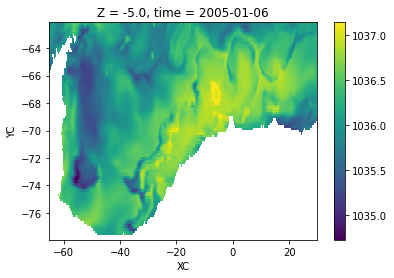

In [24]:
sigma2.isel(Z=0, time=0).where(mask).plot()

In [25]:
sigma2_m = sigma2.where(mask)

In [26]:
sigma2_m

,Array,Chunk
Bytes,3.71 GiB,8.68 MiB
Shape,"(438, 42, 95, 570)","(1, 42, 95, 570)"
Count,7897 Tasks,438 Chunks
Type,float32,numpy.ndarray


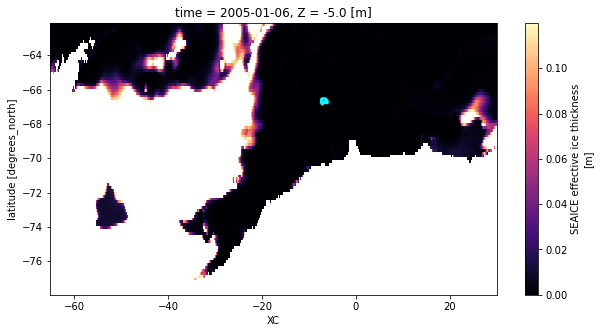

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
C = sigma2_m.isel(Z=0, time=0).plot.contour(colors='cyan', levels=[1037.125], ax=ax)
# makes first contour thicker and cyan, can do for contour line dividing bottom water (index 25 w current arange)
C.collections[0].set_linewidth(3)
plt.clabel(C)
sit_thresh.isel(time=0).plot(cmap='magma')

## 2005

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: The following kwargs were not used by contour: 'linewidth', 'label'
  primitive = ax.contour(x, y, z, **kwargs)


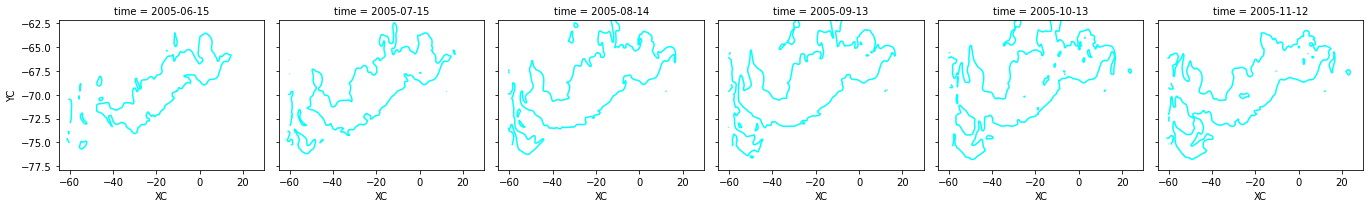

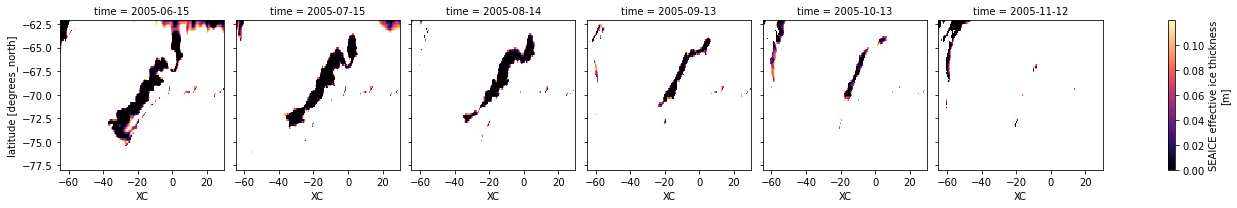

In [35]:
sigma2_m.sel(Z=0, time=['2005-06-14', '2005-07-15', '2005-08-15', '2005-09-15', '2005-10-14', '2005-11-14'],
                method='nearest').plot.contour(colors='cyan', levels=[1037.125], linewidth=8, label='', col='time')

sit_thresh.sel(time=['2005-06-14', '2005-07-15', '2005-08-15', '2005-09-15', '2005-10-14', '2005-11-14'],
                method='nearest').plot(cmap='magma', col='time');

## 2006

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: The following kwargs were not used by contour: 'linewidth', 'label'
  primitive = ax.contour(x, y, z, **kwargs)


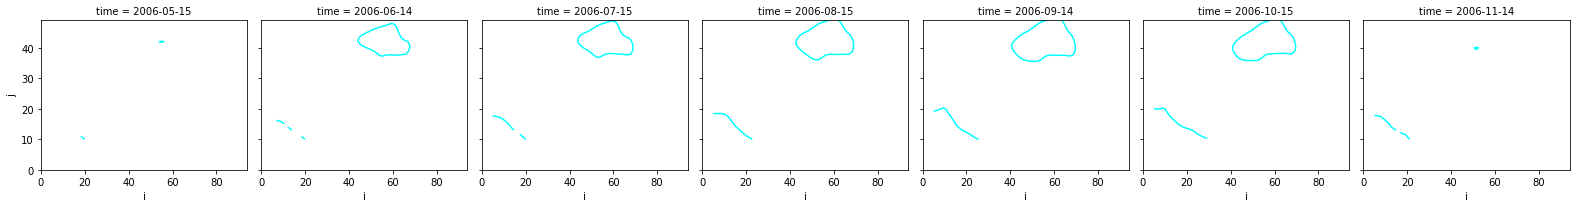

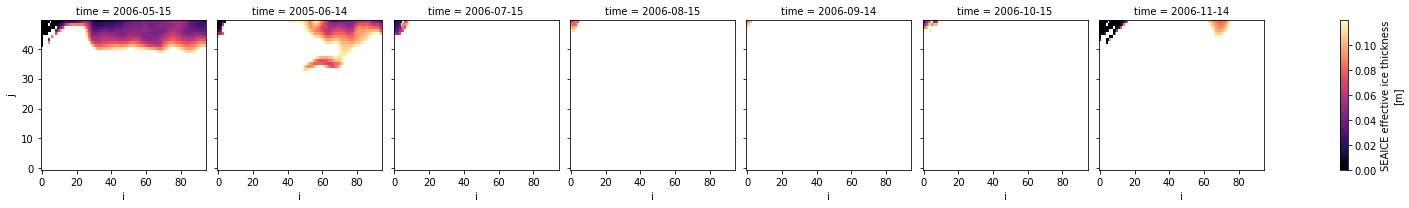

In [42]:
sigma2_m.sel(k=0, time=['2006-05-14','2006-06-14', '2006-07-15', '2006-08-15', '2006-09-15', '2006-10-14', '2006-11-14'],
                method='nearest').plot.contour(colors='cyan', levels=[1037.125], linewidth=8, label='', col='time')

sit_thresh.sel(time=['2006-05-14', '2005-06-14', '2006-07-15', '2006-08-15', '2006-09-15', '2006-10-14', '2006-11-14'],
                method='nearest').plot(cmap='magma', col='time');

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: The following kwargs were not used by contour: 'linewidth', 'label'
  primitive = ax.contour(x, y, z, **kwargs)


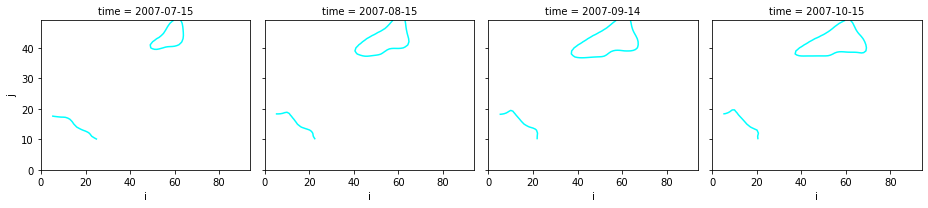

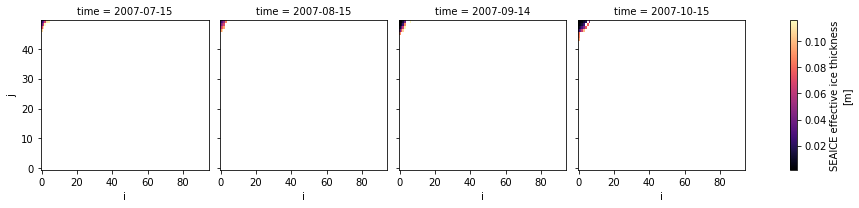

In [43]:
sigma2_m.sel(k=0, time=['2007-07-15', '2007-08-15', '2007-09-15', '2007-10-14'],
                method='nearest').plot.contour(colors='cyan', levels=[1037.125], linewidth=8, label='', col='time')

sit_thresh.sel(time=['2007-07-15', '2007-08-15', '2007-09-15', '2007-10-14'],
                method='nearest').plot(cmap='magma', col='time');

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: The following kwargs were not used by contour: 'linewidth', 'label'
  primitive = ax.contour(x, y, z, **kwargs)


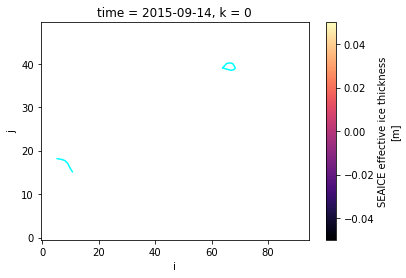

In [48]:
fig, ax = plt.subplots()

sigma2_m.sel(k=0, time='2015-09-14', method='nearest').plot.contour(colors='cyan', ax=ax,
                                                                    levels=[1037.125], linewidth=8, label='')

sit_thresh.sel(time='2015-09-14', method='nearest').plot(cmap='magma', ax=ax);

In [38]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [41]:
lon = coords.XC
lat = coords.YC

In [44]:
def contour_sit(da, fig, tt, *args, **kwargs):
    
    proj = ccrs.Mercator() #with Mercator you can put lat lon values
    fig, ax = plt.subplots(figsize=(15,15), subplot_kw=dict(projection=proj))
    
    ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
    
    C = ax.contour(lon, lat, sigma2_m.sel(time=tt, method='nearest', Z=0), colors='cyan', 
                   levels=[1037.125], linewidth=8, transform=ccrs.PlateCarree())
    #C.collections[0].set_linewidth(3)
    
    #sit = da.isel(time=tt).plot(cmap=plt.get_cmap('magma'), ax=ax)
    
    sit = ax.pcolormesh(lon, lat, da.sel(time=tt, method='nearest'), transform=ccrs.PlateCarree(), cmap='magma')
    
    cb = fig.colorbar(sit, ax=ax, shrink=0.4)
    cb.set_label("Sea Ice Thickness Threshold <=0.12m", labelpad=12, fontsize=13)
    g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    g1.xlabels_top = False
    g1.ylabels_right = False
    date = str(da.time.sel(time=tt, method='nearest').dt.strftime('%Y-%m-%d').values)
    ax.set_title(date, fontsize=26);
    
    return ax, sit

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(<GeoAxesSubplot:title={'center':'2005-09-13'}>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fd516eccaf0>)

<Figure size 1080x1080 with 0 Axes>

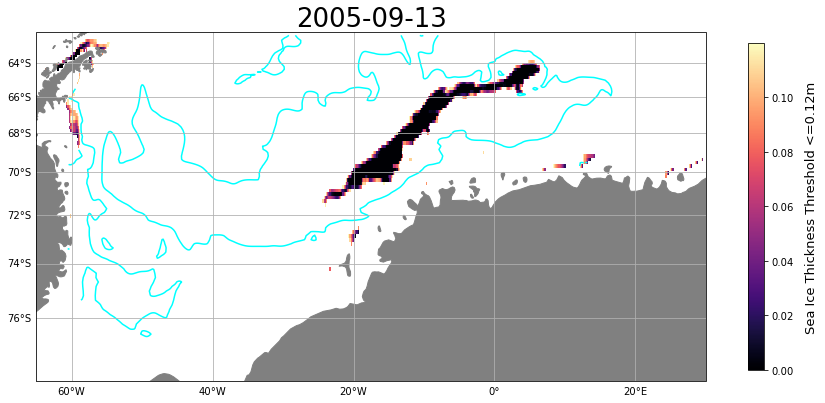

In [45]:
fig = plt.figure(figsize=(15,15))

contour_sit(sit_thresh, fig, '2005-09-14')